---
---

In [57]:
# Setup and Imports

In [113]:
!pip install kagglehub nltk wordcloud transformers pandas matplotlib seaborn scikit-learn --quiet


In [58]:
import os

In [59]:
import re

In [60]:
import json

In [61]:
import pandas as pd

In [62]:
import numpy as np

In [63]:
import nltk

In [64]:
import torch

In [65]:
import matplotlib.pyplot as plt

In [66]:
import seaborn as sns

In [67]:
from wordcloud import WordCloud

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [69]:
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [70]:
from transformers import pipeline

In [71]:
from nltk.tokenize import word_tokenize

In [72]:
from nltk.corpus import stopwords

In [73]:
from nltk.stem import WordNetLemmatizer

---
--

---
---

In [74]:
# Download NLTK Resources

In [75]:
nltk.download('punkt', quiet=True)

True

In [76]:
nltk.download('stopwords', quiet=True)

True

In [77]:
nltk.download('wordnet', quiet=True)

True

In [78]:
nltk.download('omw-1.4', quiet=True)

True

---
---

---
---

In [79]:
# Load Dataset and inspect

In [80]:
dataset_path = "/kaggle/input/news-headlines-dataset-for-sarcasm-detection"

In [81]:
file_name = "Sarcasm_Headlines_Dataset.json"

In [82]:
# Load json lines into DataFrame

In [83]:
df = pd.read_json(os.path.join(dataset_path, file_name), lines=True)

In [84]:
# Inspect Dataset Immediately

In [85]:
print("\nDataset sample (first 5 rows):")
print(df.head())


Dataset sample (first 5 rows):
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [86]:
print("\nDataset info:")
print(df.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB
None


In [87]:
print("\nDataset description:")
print(df.describe(include='all'))


Dataset description:
                                             article_link  \
count                                               26709   
unique                                              26708   
top     https://www.huffingtonpost.comhttp://nymag.com...   
freq                                                    2   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                           headline  is_sarcastic  
count                                         26709  26709.000000  
unique                                        26602           NaN  
top     the 20 funniest tweets from women

---
---

---
---

In [88]:
# Rename Columns for consistency (optional, already good)

In [89]:
df = df.rename(columns={"headline": "headline", "is_sarcastic": "label"})

In [90]:
df = df[["headline", "label"]]

In [91]:
# Define Spiritual Keywords (merged from both scripts)

In [92]:
spiritual_keywords = {
    'spiritual': ['spirit', 'soul', 'divine', 'sacred', 'holy', 'prayer', 'meditation', 'spiritual', 'inner peace', 'awakening', 'karma'],
    'transcendence': ['transcend', 'beyond', 'higher', 'consciousness', 'enlightenment', 'nirvana', 'chakra', 'cosmic', 'aura'],
    'connection': ['connect', 'unity', 'one', 'whole', 'belong', 'love', 'compassion', 'oneness', 'gratitude', 'peace', 'mindfulness'],
    'transformation': ['transform', 'change', 'awaken', 'enlighten', 'rebirth', 'rebirth', 'transformation', 'healing', 'forgiveness', 'growth', 'renewal'],
    'mystical': ['mystic', 'vision', 'presence', 'god', 'angel', 'miracle', 'mystic']
}

---
---

---
---

In [93]:
# Text Preprocessing

In [94]:
def preprocess_text(text):
    # Clean text
    text = re.sub(r"[^\w\s]", "", str(text).lower())
    # Tokenize
    tokens = word_tokenize(text)
    # Remove non-alpha tokens and stopwords
    tokens = [t for t in tokens if t.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

In [95]:
df['processed_text'] = df['headline'].apply(preprocess_text)

In [96]:
# Compute Spiritual Score and Category

In [97]:
def detect_spiritual_content(text):
    scores = {cat: 0 for cat in spiritual_keywords}
    words = text.split()
    for word in words:
        for cat, keywords in spiritual_keywords.items():
            if word in keywords:
                scores[cat] += 1
    total = sum(scores.values())
    dominant = max(scores, key=scores.get) if total > 0 else None
    return total, dominant, scores

In [98]:
def label_experience(score, category):
    if score == 0 or not category:
        return None
    if score == 1:
        return f"Low {category}"
    elif score == 2:
        return f"Moderate {category}"
    else:
        return f"High {category}"

In [99]:
df[['spiritual_score', 'dominant_category', 'scores_dict']] = df['processed_text'].apply(
    lambda x: pd.Series(detect_spiritual_content(x))
)

In [100]:
df['spiritual_label'] = df.apply(lambda row: label_experience(row['spiritual_score'], row['dominant_category']), axis=1)


---
---

---
---

In [101]:
# Sentiment Analysis Setup

In [102]:
device = 0 if torch.cuda.is_available() else -1
try:
    sentiment_analyzer = pipeline("sentiment-analysis", device=device)
    df['sentiment'] = df['headline'].apply(lambda x: sentiment_analyzer(str(x)[:512])[0]['label'])
except Exception as e:
    print("Sentiment analysis error:", e)
    df['sentiment'] = 'ANALYSIS_ERROR'

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


---
---

---
---

In [103]:
# Visualization

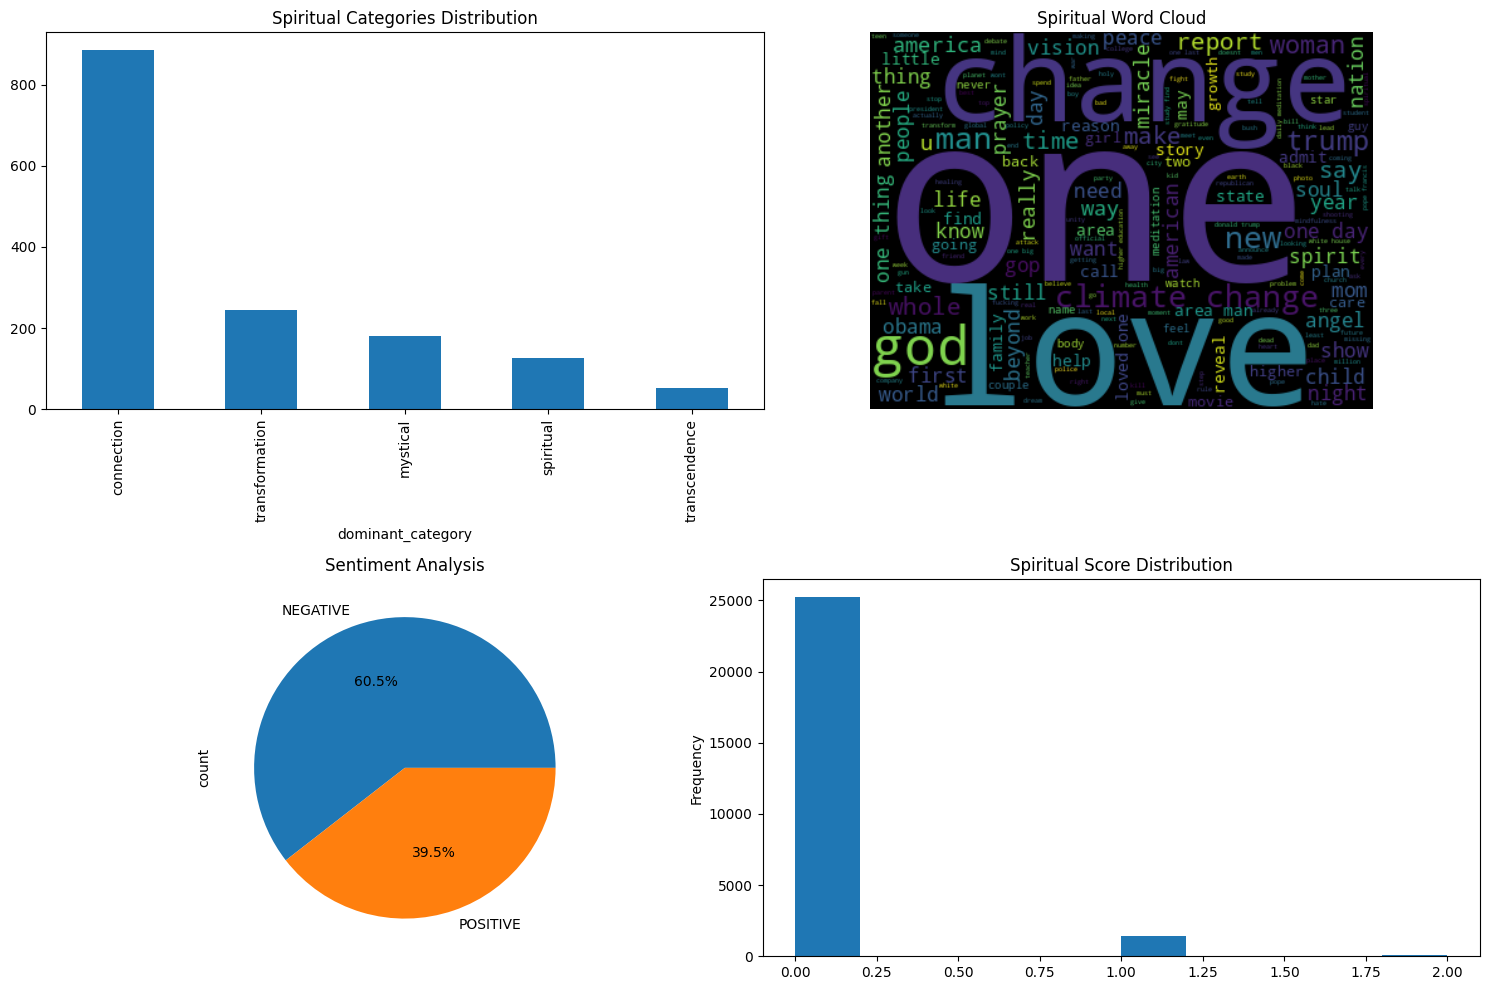

In [104]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
df['dominant_category'].value_counts().plot(kind='bar')
plt.title('Spiritual Categories Distribution')

plt.subplot(2, 2, 2)
wordcloud_text = ' '.join(df[df['spiritual_score'] > 0]['processed_text'])
if len(wordcloud_text) > 10:
    wordcloud = WordCloud(width=400, height=300).generate(wordcloud_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Spiritual Word Cloud')
else:
    plt.text(0.5, 0.5, 'Not enough spiritual content', ha='center')

plt.subplot(2, 2, 3)
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Analysis')

plt.subplot(2, 2, 4)
df['spiritual_score'].plot(kind='hist', bins=10)
plt.title('Spiritual Score Distribution')

plt.tight_layout()
plt.show()


---
---

----
----

In [105]:
# Topic Modeling (NMF preferred for this merge)

In [106]:
spiritual_texts = df[df['spiritual_score'] > 0]['processed_text']

In [107]:
if len(spiritual_texts) > 10:
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(spiritual_texts)
    nmf_model = NMF(n_components=3, random_state=42)
    nmf_model.fit(X)
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(nmf_model.components_):
        print(f"\nTopic {idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
else:
    print("Not enough spiritual content for topic modeling.")


Topic 0:
love reason story new fall man mom make america child

Topic 1:
change climate trump woman hurricane new man time american say

Topic 2:
god man area pope new admits woman gun oh loses


---
---

---
---

In [108]:
# Save Results

In [109]:
output_file = "spiritual_analysis_results.csv"

In [110]:
df.to_csv(output_file, index=False)
print(f"\nAnalysis complete! Results saved to {output_file}")


Analysis complete! Results saved to spiritual_analysis_results.csv


In [111]:
# Show Top 20 Spiritual Headlines

In [112]:
print("\nTop 20 headlines with spiritual labels:")
print(df[df['spiritual_label'].notna()][
    ["headline", "spiritual_score", "dominant_category", "spiritual_label"]
].head(20))


Top 20 headlines with spiritual labels:
                                              headline  spiritual_score  \
66   one of the planet's most powerful forces for c...                2   
80   90 zen teachers pledge to change culture that ...                1   
86   doctors restore ken burns' full-color vision a...                1   
95   hunter s. thompson shoots mouth off one last time                1   
115  scott pruitt (sort of) answers whether trump b...                1   
119  air force will no longer require 'so help me g...                1   
132                  10 qualities of your inner spirit                1   
133  chubby jewish boy dreams of one day being next...                1   
141  6 things no one tells women about their weight...                1   
160    the secret behind a one day project going viral                1   
162  new movie taps into nation's love of rapping k...                1   
185   god humbled to be the answer to 'jeopardy!' clue     

---
---